In [110]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [118]:
class MultiArmBandit():
    def __init__(self, mean_rewards, reward_variances) -> None:
        if mean_rewards.shape == reward_variances.shape:
            self.n_levers = len(mean_rewards)
            self.mean_rewards = mean_rewards
            self.reward_variances = reward_variances
        else:
            print("ERROR: mean_rewards has different length than reward_variances!")

    def play_machine(self, lever):
        if lever < self.n_levers:
            return np.random.normal(self.mean_rewards[lever], self.reward_variances[lever])
        else:
            return None
        
class GreedyBanditAgent():
    def __init__(self, n_levers, default_value=0.5) -> None:
        self.n_levers = n_levers
        self.q_values = np.ones(n_levers)*default_value
        self.n_actions = np.zeros(n_levers)
        self.a_rewards = np.zeros(n_levers)

    def action(self):
        potential_actions = np.argwhere(self.q_values == np.max(self.q_values)).flatten()
        a = np.random.choice(potential_actions)
        #a = np.argmax(self.q_values)
        return a
    
    def update_values(self, reward, action):
        self.a_rewards[action] += reward
        self.n_actions[action] += 1
        self.q_values[action] = self.a_rewards[action]/self.n_actions[action]

    def update_values_incremental(self, reward, action):
        self.n_actions[action] += 1
        self.q_values[action] = self.q_values[action] + (reward - self.q_values[action]) / self.n_actions[action]   # NewEstimate <-- OldEstimate + StepSize * [Target - OldEstimate]

class EpsilonGreedyBanditAgent():
    def __init__(self, n_levers, epsilon, default_value=0.5, step_size=None) -> None:
        self.epsilon = epsilon
        self.n_levers = n_levers
        self.q_values = np.ones(n_levers)*default_value
        self.n_actions = np.zeros(n_levers)
        self.a_rewards = np.zeros(n_levers)

        self.step_size = step_size

    def action(self):
        if np.random.uniform(0,1) < self.epsilon:
            a = np.random.randint(0, self.n_levers)
        else:
            #a = np.argmax(self.q_values)
            potential_actions = np.argwhere(self.q_values == np.max(self.q_values)).flatten()
            a = np.random.choice(potential_actions)
        
        return a
    
    def update_values(self, reward, action):
        self.a_rewards[action] += reward
        self.n_actions[action] += 1
        self.q_values[action] = self.a_rewards[action]/self.n_actions[action]

    def update_values_incremental(self, reward, action):
        self.n_actions[action] += 1
        
        if self.step_size == None:
            alpha = 1/self.n_actions[action]    # estimating values using sample average
        else:
            alpha = self.step_size              # recency weighted average (suitable for non-stationary problems because of emphasis on recent rewards)
        
        self.q_values[action] = self.q_values[action] + (alpha*(reward - self.q_values[action]))   # NewEstimate <-- OldEstimate + StepSize * [Target - OldEstimate]


class UCBBanditAgent():
    def __init__(self, n_levers, confidence, default_value=0.5, step_size=None) -> None:
        self.n_levers = n_levers
        self.confidence = confidence
        self.q_values = np.ones(n_levers)*default_value
        self.n_actions = np.zeros(n_levers)
        self.a_rewards = np.zeros(n_levers)

        self.step_size = step_size
    
    def action(self):
        maximizing_actions = np.argwhere(self.n_actions==0).flatten()
        if len(maximizing_actions) > 0:
            a = np.random.choice(maximizing_actions)
        else:
            a = np.argmax(self.q_values + self.confidence*np.sqrt(np.log(np.sum(self.n_actions))/self.n_actions))
        return a

    def update_values_incremental(self, reward, action):
        self.n_actions[action] += 1
        
        if self.step_size == None:
            alpha = 1/self.n_actions[action]    # estimating values using sample average
        else:
            alpha = self.step_size              # recency weighted average (suitable for non-stationary problems because of emphasis on recent rewards)
        
        self.q_values[action] = self.q_values[action] + (alpha*(reward - self.q_values[action]))   # NewEstimate <-- OldEstimate + StepSize * [Target - OldEstimate]



In [119]:
a = np.array([1,2,3,4])
b = np.array([1,2,3,4])

print(np.argmax(a+b*2))
print(len(a))

3
4


In [120]:
overall_rewards = []
overall_optimal_actions = []

n_runs = 2000
max_steps = 1000

for i in tqdm(range(n_runs)):
    action_values = np.random.normal(0, 1, size=10)
    optimal_action = np.argmax(action_values)
    bandit = MultiArmBandit(
        mean_rewards=action_values,
        reward_variances=np.ones_like(action_values)
    )
    greedy_agent = GreedyBanditAgent(
        n_levers=10
    )
    epsilon_greedy_agent_001 = EpsilonGreedyBanditAgent(
        n_levers=10,
        epsilon=0.01
    )
    epsilon_greedy_agent01 = EpsilonGreedyBanditAgent(
        n_levers=10,
        epsilon=0.1
    )
    ## Optimistic Initial Values ##
    epsilon_greedy_agent0_optimistic = EpsilonGreedyBanditAgent(
        n_levers=10,
        epsilon=0,
        default_value=5,    # encourages exploration in the beginning but as no exploratory effect if reward distribution changes over time
        step_size=0.1
    )
    epsilon_greedy_agent01_realistic = EpsilonGreedyBanditAgent(
        n_levers=10,
        epsilon=0.1,
        default_value=0,
        step_size=0.1
    )
    ## Upper-Confidence-Bound Action Selection ##
    ucb_agent = UCBBanditAgent(
        n_levers=10,
        confidence=2,
        
    )


    agent_list = [
        greedy_agent, 
        epsilon_greedy_agent_001, 
        epsilon_greedy_agent01, 
        epsilon_greedy_agent0_optimistic, 
        epsilon_greedy_agent01_realistic,
        ucb_agent
    ]

    collected_rewards = [[] for _ in range(len(agent_list))]
    collected_optimal_actions = [[] for _ in range(len(agent_list))]

    for step in range(max_steps):
        for j, agent in enumerate(agent_list):
            action = agent.action()
            reward = bandit.play_machine(lever=action)
            agent.update_values_incremental(reward, action)

            collected_rewards[j].append(reward)

            if action == optimal_action:
                collected_optimal_actions[j].append(1)
            else:
                collected_optimal_actions[j].append(0)
    
    overall_rewards.append(collected_rewards)
    overall_optimal_actions.append(collected_optimal_actions)

100%|██████████| 2000/2000 [14:54<00:00,  2.24it/s]


In [121]:
agent_1 = np.zeros((max_steps))
agent_2 = np.zeros((max_steps))
agent_3 = np.zeros((max_steps))
agent_4 = np.zeros((max_steps))
agent_5 = np.zeros((max_steps))
agent_6 = np.zeros((max_steps))
for i in range(max_steps):
    for j in range(n_runs):
        agent_1[i] += overall_rewards[j][0][i]
        agent_2[i] += overall_rewards[j][1][i]
        agent_3[i] += overall_rewards[j][2][i]
        agent_4[i] += overall_rewards[j][3][i]
        agent_5[i] += overall_rewards[j][4][i]
        agent_6[i] += overall_rewards[j][5][i]

agent_1 = agent_1/n_runs
agent_2 = agent_2/n_runs
agent_3 = agent_3/n_runs
agent_4 = agent_4/n_runs
agent_5 = agent_5/n_runs
agent_6 = agent_6/n_runs

agent_1_actions = np.zeros((max_steps))
agent_2_actions = np.zeros((max_steps))
agent_3_actions = np.zeros((max_steps))
agent_4_actions = np.zeros((max_steps))
agent_5_actions = np.zeros((max_steps))
agent_6_actions = np.zeros((max_steps))
for i in range(max_steps):
    for j in range(n_runs):
        agent_1_actions[i] += overall_optimal_actions[j][0][i]
        agent_2_actions[i] += overall_optimal_actions[j][1][i]
        agent_3_actions[i] += overall_optimal_actions[j][2][i]
        agent_4_actions[i] += overall_optimal_actions[j][3][i]
        agent_5_actions[i] += overall_optimal_actions[j][4][i]
        agent_6_actions[i] += overall_optimal_actions[j][5][i]

agent_1_actions = agent_1_actions/n_runs
agent_2_actions = agent_2_actions/n_runs
agent_3_actions = agent_3_actions/n_runs
agent_4_actions = agent_4_actions/n_runs
agent_5_actions = agent_5_actions/n_runs
agent_6_actions = agent_6_actions/n_runs

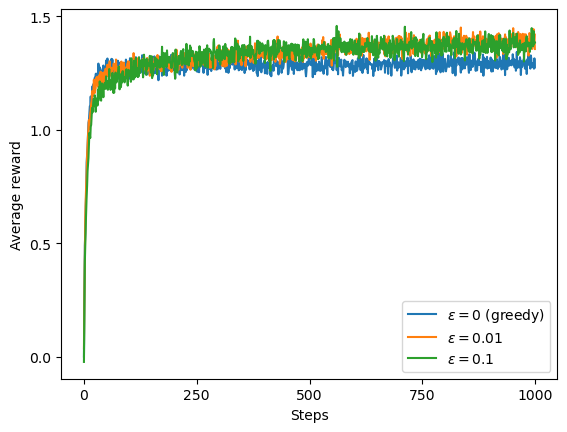

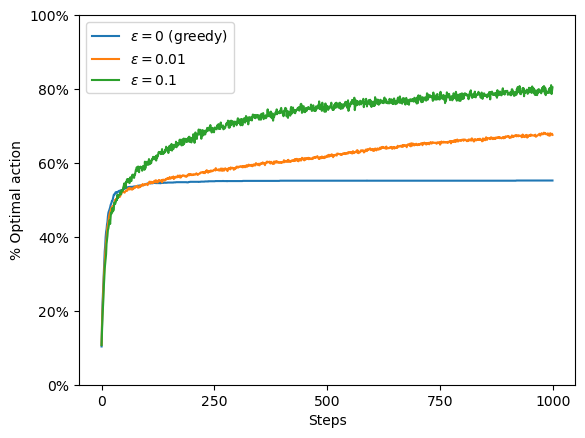

In [122]:
plt.plot(range(max_steps), agent_1, label="$\epsilon = 0$ (greedy)")
plt.plot(range(max_steps), agent_2, label="$\epsilon = 0.01$")
plt.plot(range(max_steps), agent_3, label="$\epsilon = 0.1$")
plt.legend()


plt.yticks([0, 0.5, 1, 1.5])
plt.xticks([0, 250, 500, 750, max_steps])
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()

plt.plot(range(max_steps), agent_1_actions, label="$\epsilon = 0$ (greedy)")
plt.plot(range(max_steps), agent_2_actions, label="$\epsilon = 0.01$")
plt.plot(range(max_steps), agent_3_actions, label="$\epsilon = 0.1$")
plt.legend()


plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], labels=["0%", "20%", "40%", "60%", "80%", "100%"])
plt.xticks([0, 250, 500, 750, max_steps])
plt.xlabel("Steps")
plt.ylabel("% Optimal action")
plt.show()

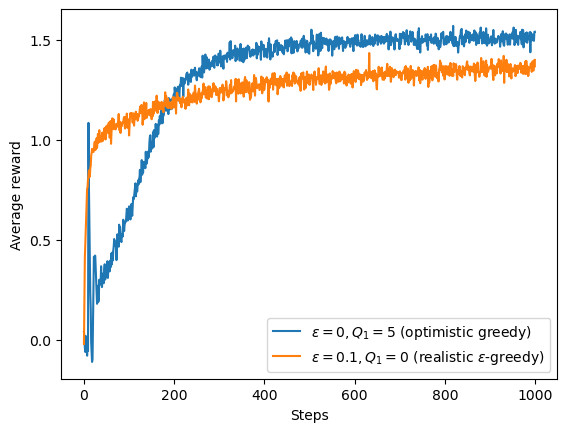

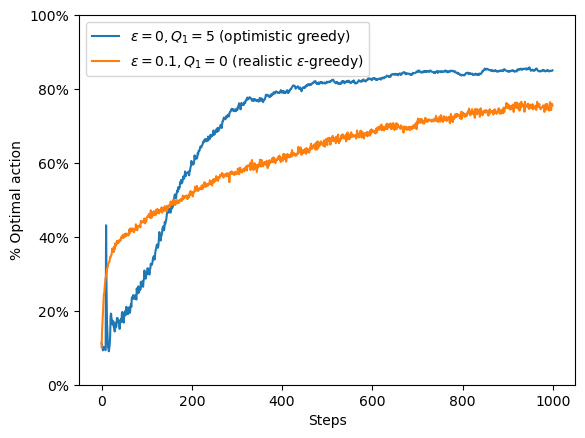

In [123]:
plt.plot(range(max_steps), agent_4, label="$\epsilon = 0, Q_1=5$ (optimistic greedy)")
plt.plot(range(max_steps), agent_5, label="$\epsilon = 0.1, Q_1=0$ (realistic $\epsilon$-greedy)")
plt.legend()


plt.yticks([0, 0.5, 1, 1.5])
plt.xticks([0, 200, 400, 600, 800, max_steps])
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()

plt.plot(range(max_steps), agent_4_actions, label="$\epsilon = 0, Q_1=5$ (optimistic greedy)")
plt.plot(range(max_steps), agent_5_actions, label="$\epsilon = 0.1, Q_1=0$ (realistic $\epsilon$-greedy)")
plt.legend()


plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], labels=["0%", "20%", "40%", "60%", "80%", "100%"])
plt.xticks([0, 200, 400, 600, 800, max_steps])
plt.xlabel("Steps")
plt.ylabel("% Optimal action")
plt.show()

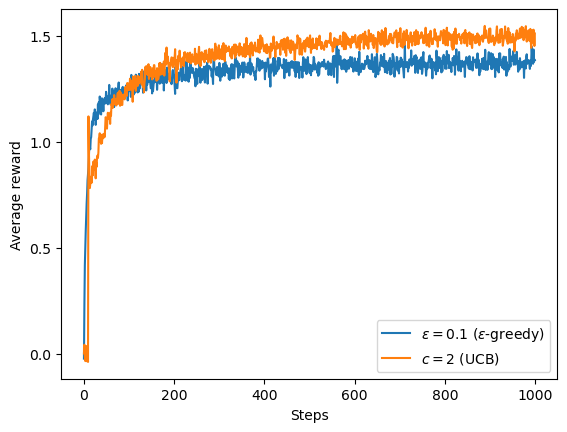

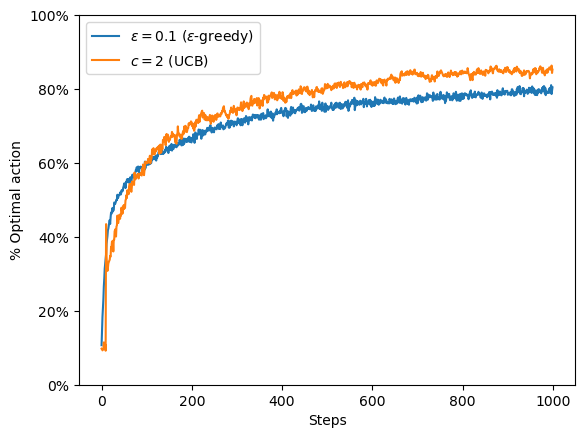

In [125]:
plt.plot(range(max_steps), agent_3, label="$\epsilon = 0.1$ ($\epsilon$-greedy)")
plt.plot(range(max_steps), agent_6, label="$c = 2$ (UCB)")
plt.legend()


plt.yticks([0, 0.5, 1, 1.5])
plt.xticks([0, 200, 400, 600, 800, max_steps])
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()

plt.plot(range(max_steps), agent_3_actions, label="$\epsilon = 0.1$ ($\epsilon$-greedy)")
plt.plot(range(max_steps), agent_6_actions, label="$c = 2$ (UCB)")
plt.legend()


plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], labels=["0%", "20%", "40%", "60%", "80%", "100%"])
plt.xticks([0, 200, 400, 600, 800, max_steps])
plt.xlabel("Steps")
plt.ylabel("% Optimal action")
plt.show()

## Gradient Bandits ##

In [150]:
from scipy.special import softmax

In [160]:
class GradientBanditWBAgent():  # with baseline
    def __init__(self, n_levers, default_value=0.5, alpha=0.1, name="Stanley") -> None:
        self.n_levers = n_levers
        self.h_values = np.ones(n_levers)*default_value
        self.n_actions = np.zeros(n_levers)
        self.a_rewards = np.zeros(n_levers)

        self.action_probabilities = softmax(self.h_values)
        self.actions = np.arange(self.n_levers)
        self.reward_average = 0
        self.alpha = alpha

        self.name = name
        
    def action(self):
        return np.random.choice(a=self.actions, p=self.action_probabilities)
    

    def update_values_incremental(self, reward, action):
        self.n_actions[action] += 1
        self.reward_average = self.reward_average + (reward - self.reward_average) / self.n_actions.sum()

        self.h_values = self.h_values + self.alpha*(reward - self.reward_average)*(np.where(self.actions==action, 1, 0)-self.action_probabilities)   # NewEstimate <-- OldEstimate + StepSize * [Target - OldEstimate]
        self.action_probabilities = softmax(self.h_values)

class GradientBanditWOBAgent(): # without baseline
    def __init__(self, n_levers, default_value=0.5, alpha=0.1, name="Stanley") -> None:
        self.n_levers = n_levers
        self.h_values = np.ones(n_levers)*default_value
        self.n_actions = np.zeros(n_levers)
        self.a_rewards = np.zeros(n_levers)

        self.action_probabilities = softmax(self.h_values)
        self.actions = np.arange(self.n_levers)
        self.reward_average = 0
        self.alpha = alpha

        self.name = name

    def action(self):
        return np.random.choice(a=self.actions, p=self.action_probabilities)
    

    def update_values_incremental(self, reward, action):
        self.n_actions[action] += 1

        self.h_values = self.h_values + self.alpha*(reward - self.reward_average)*(np.where(self.actions==action, 1, 0)-self.action_probabilities)   # NewEstimate <-- OldEstimate + StepSize * [Target - OldEstimate]
        self.action_probabilities = softmax(self.h_values)

In [193]:
gb_overall_rewards = []
gb_overall_optimal_actions = []

n_runs = 2000
max_steps = 1000

for i in tqdm(range(n_runs)):
    action_values = np.random.normal(4, 1, size=10)
    optimal_action = np.argmax(action_values)

    bandit = MultiArmBandit(
        mean_rewards=action_values,
        reward_variances=np.ones_like(action_values)
    )

    gb_gradient_agent_wb = GradientBanditWBAgent(
        n_levers=10,
        default_value=0,
        alpha=0.1,
        name="wb"
    )
    gb_gradient_agent_wob = GradientBanditWOBAgent(
        n_levers=10,
        default_value=0,
        alpha=0.1,
        name="wob"
    )
    gb_gradient_agent_wb_2 = GradientBanditWBAgent(
        n_levers=10,
        default_value=0,
        alpha=0.4,
        name="wb_2"
    )
    gb_gradient_agent_wob_2 = GradientBanditWOBAgent(
        n_levers=10,
        default_value=0,
        alpha=0.4,
        name="wob_2"
    )

    gb_agent_list = [
        gb_gradient_agent_wb, 
        gb_gradient_agent_wob,
        gb_gradient_agent_wb_2,
        gb_gradient_agent_wob_2
    ]

    collected_rewards = [[] for _ in range(len(gb_agent_list))]
    collected_optimal_actions = [[] for _ in range(len(gb_agent_list))]

    for step in range(max_steps):
        for j, agent in enumerate(gb_agent_list):
            action = agent.action()
            reward = bandit.play_machine(lever=action)
            agent.update_values_incremental(reward, action)

            collected_rewards[j].append(reward)

            if action == optimal_action:
                collected_optimal_actions[j].append(1)
            else:
                collected_optimal_actions[j].append(0)
    
    gb_overall_rewards.append(collected_rewards)
    gb_overall_optimal_actions.append(collected_optimal_actions)

100%|██████████| 2000/2000 [12:49<00:00,  2.60it/s]


In [194]:
agent_dict = {}
for agent in gb_agent_list:
    agent_dict[agent.name] = {
        "avg_reward": np.zeros((max_steps)),
        "ratio_opt_action": np.zeros((max_steps))
    }

for i in range(max_steps):
    for j in range(n_runs):
        for m, agent in enumerate(gb_agent_list):
            agent_dict[agent.name]["avg_reward"][i] = agent_dict[agent.name]["avg_reward"][i] + (gb_overall_rewards[j][m][i] - agent_dict[agent.name]["avg_reward"][i]) / (j+1)
            agent_dict[agent.name]["ratio_opt_action"][i] = agent_dict[agent.name]["ratio_opt_action"][i] + (gb_overall_optimal_actions[j][m][i] - agent_dict[agent.name]["ratio_opt_action"][i]) / (j+1)

In [188]:
gb_agent_1 = np.zeros((max_steps))
gb_agent_2 = np.zeros((max_steps))


for i in range(max_steps):
    for j in range(n_runs):
        gb_agent_1[i] += gb_overall_rewards[j][0][i]
        gb_agent_2[i] += gb_overall_rewards[j][1][i]



gb_agent_1 = gb_agent_1/n_runs
gb_agent_2 = gb_agent_2/n_runs



gb_agent_1_actions = np.zeros((max_steps))
gb_agent_2_actions = np.zeros((max_steps))


for i in range(max_steps):
    for j in range(n_runs):
        gb_agent_1_actions[i] += gb_overall_optimal_actions[j][0][i]
        gb_agent_2_actions[i] += gb_overall_optimal_actions[j][1][i]



gb_agent_1_actions = gb_agent_1_actions/n_runs
gb_agent_2_actions = gb_agent_2_actions/n_runs



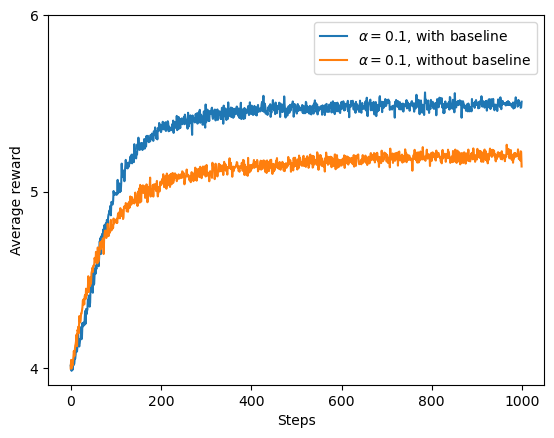

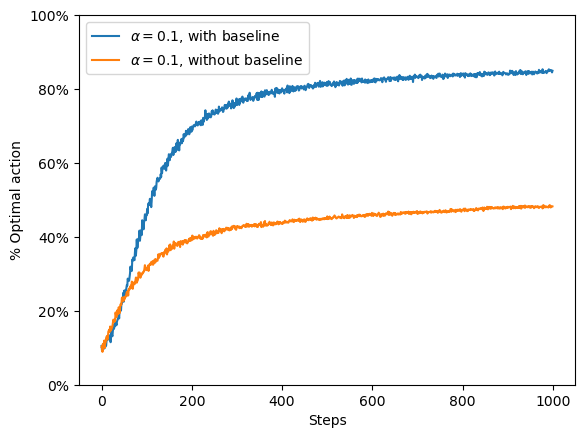

In [189]:

#for agent in gb_agent_list:
plt.plot(range(max_steps), gb_agent_1, label=r"$\alpha=0.1$, with baseline")
plt.plot(range(max_steps), gb_agent_2, label=r"$\alpha=0.1$, without baseline")
plt.legend()


plt.yticks([4, 5, 6])
plt.xticks([0, 200, 400, 600, 800, max_steps])
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()


#for agent in gb_agent_list:
plt.plot(range(max_steps), gb_agent_1_actions, label=r"$\alpha=0.1$, with baseline")
#plt.plot(range(max_steps), agent_3_actions, label="$\epsilon = 0.1$ ($\epsilon$-greedy)")
plt.plot(range(max_steps), gb_agent_2_actions, label=r"$\alpha=0.1$, without baseline")
plt.legend()


plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], labels=["0%", "20%", "40%", "60%", "80%", "100%"])
plt.xticks([0, 200, 400, 600, 800, max_steps])
plt.xlabel("Steps")
plt.ylabel("% Optimal action")
plt.show()

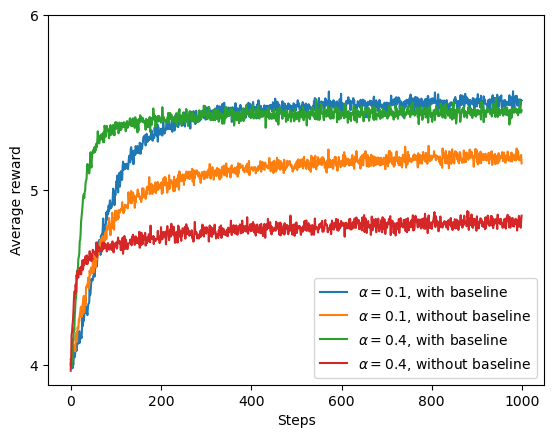

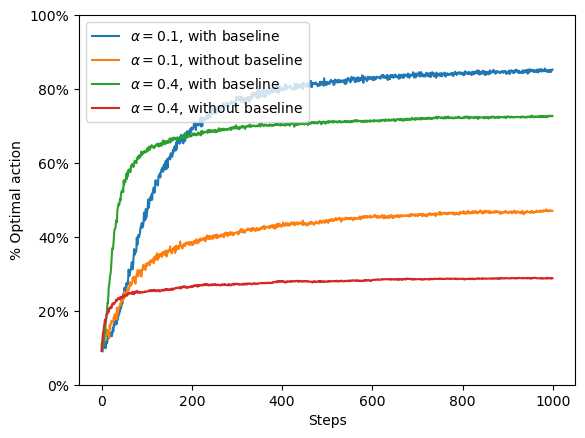

In [195]:
labels = [r"$\alpha=0.1$, with baseline", r"$\alpha=0.1$, without baseline", r"$\alpha=0.4$, with baseline", r"$\alpha=0.4$, without baseline"]
for agent, label in zip(gb_agent_list, labels):
    plt.plot(range(max_steps), agent_dict[agent.name]["avg_reward"], label=label)
#plt.plot(range(max_steps), gb_agent_2, label=r"$\alpha=0.1$, without baseline")
plt.legend()


plt.yticks([4, 5, 6])
plt.xticks([0, 200, 400, 600, 800, max_steps])
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()


for agent, label in zip(gb_agent_list, labels):
    plt.plot(range(max_steps), agent_dict[agent.name]["ratio_opt_action"], label=label)
#plt.plot(range(max_steps), agent_3_actions, label="$\epsilon = 0.1$ ($\epsilon$-greedy)")
#plt.plot(range(max_steps), gb_agent_2_actions, label=r"$\alpha=0.1$, without baseline")
plt.legend()


plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], labels=["0%", "20%", "40%", "60%", "80%", "100%"])
plt.xticks([0, 200, 400, 600, 800, max_steps])
plt.xlabel("Steps")
plt.ylabel("% Optimal action")
plt.show()